In [46]:
import pandas as pd
import numpy as np
from typing import Tuple
import nba_on_court as noc
from sklearn.linear_model import RidgeCV
from sklearn.model_selection import train_test_split
import sklearn
import matplotlib.pyplot as plt


Filtering data where stints and turnovers both have values for 'player_1_team_abbreviation'

In [2]:
_BASE_FEATURES  = [
    'SCOREMARGIN',
    'TURNOVERS', 
    'PLAYER1_ID', 
    'AWAY_PLAYER1', 'AWAY_PLAYER2', 'AWAY_PLAYER3', 'AWAY_PLAYER4', 'AWAY_PLAYER5', 
    'HOME_PLAYER1', 'HOME_PLAYER2', 'HOME_PLAYER3', 'HOME_PLAYER4', 'HOME_PLAYER5'
]

def preprocess_season(season: pd.DataFrame) -> pd.DataFrame:
    '''
    Given a full season of raw data, preprocess the data
    and return the resulting DataFrame. Note that this
    is essentially `preprocess_game` but for an entire season.

    This will return a DataFrame with the following features:
      `SCOREMARGIN`: The score margin of the stint. Note that positive means in favor for home, negative in favor for away.
      `TURNOVERS`: Indicator of whether the stint resulted in a turnover.
      `BALL_ID`: (Presumed to be) the player who possessed the ball during the stint.
      `PM`: The Plus-Minus of the stint. See SCOREMARGIN for meaning of the sign.
      `[AWAY|HOME]_PLAYER[NUM]`: Player ID of an Away/Home player.
    '''
    games = pd.unique(season['GAME_ID'])
    list_of_game_data = []

    for game in games:
        current = season[season['GAME_ID'] == game].reset_index(drop=True)
        current = noc.players_on_court(current)
        list_of_game_data.append(preprocess_game(current))

    return pd.concat(list_of_game_data, ignore_index=True)

def preprocess_game(game_data: pd.DataFrame) -> pd.DataFrame:
    '''
    Given the full data of a game (including players on court), 
    preprocess the game data and return the result.

    This will return a DataFrame with the following features:
      `SCOREMARGIN`: The score margin of the stint. Note that positive means in favor for home, negative in favor for away.
      `TURNOVERS`: Indicator of whether the stint resulted in a turnover.
      `BALL_ID`: (Presumed to be) the player who possessed the ball during the stint.
      `PM`: The Plus-Minus of the stint. See SCOREMARGIN for meaning of the sign.
      `[AWAY|HOME]_PLAYER[NUM]`: Player ID of an Away/Home player.
    '''
    # extract features we care about
    subset = game_data[_BASE_FEATURES]
    subset.rename(columns={'PLAYER1_ID': 'BALL_ID'}, inplace=True)

    # have to preprocess stints that end in scores differently from stints that end in turnovers
    # because otherwise the PM can't be calculated
    scores = subset[~subset['SCOREMARGIN'].isna()].replace('TIE', 0).reset_index(drop=True)
    scores['PM'] = scores['SCOREMARGIN'].astype(np.int64).diff().replace(np.nan, 0)
    scores.at[0, 'PM'] = np.int64(scores.at[0, 'SCOREMARGIN']) # manually add in the first PM
    score_stints = scores[(scores['TURNOVERS'] == 0) & ((scores['BALL_ID'].isna() == False) & (scores['BALL_ID'] != 0))]

    turnovers = subset[subset['TURNOVERS'] == 1].reset_index(drop=True)
    turnovers['SCOREMARGIN'].fillna(0, inplace=True)
    turnovers['PM'] = np.zeros(len(turnovers), dtype=np.int64)
    turnover_stints = turnovers[((turnovers['BALL_ID'].isna() == False) & (turnovers['BALL_ID'] != 0))]

    return pd.concat([score_stints, turnover_stints], ignore_index=True)

data = preprocess_season(pd.read_csv('data/combined_data_2022.csv'))


In [6]:
data = pd.read_csv('data/processed_data_2022.csv', index_col=0)
data.shape

(12498, 14)

Creating design matrix with offensive and defensive coefficients for each player

In [35]:
_AWAY_LIST = ['AWAY_PLAYER1', 'AWAY_PLAYER2', 'AWAY_PLAYER3', 'AWAY_PLAYER4', 'AWAY_PLAYER5']
_HOME_LIST = ['HOME_PLAYER1', 'HOME_PLAYER2', 'HOME_PLAYER3', 'HOME_PLAYER4', 'HOME_PLAYER5']

def _determine_coefficient_odrapm(row: pd.Series, player_id: int, offensive: bool) -> int:
    '''
    Determines whether a player's coefficient is -1, 0, 1 in a given stint for Offensive/Defensive RAPM model.

    This is meant to be used in the `get_design_matrix` function.
    '''
    

    away = row[_AWAY_LIST].values
    home = row[_HOME_LIST].values
    away_is_offense = row['BALL_ID'] in away # True if Away is offensive team
    away_is_offense = away_is_offense if offensive else not away_is_offense # Basically, change 'defense' case to 'offense' case

    if player_id in away and away_is_offense:
        return -1
    elif player_id in home and not away_is_offense:
        return 1
    else:
        return 0

In [36]:
def get_design_matrix_odrapm(game_data: pd.DataFrame, *, return_players: bool = False) -> np.ndarray | Tuple[np.ndarray, np.ndarray]:
    '''
    Given a preprocessed game/season of data, return a design matrix for a regression model.
    See `preprocess_game`

    Each row of the matrix will correspond to a stint.
    Even columns (0, 2, 4, ...) correspond to offensive indicators (i.e. filled iff player is on offense).\n
    Odd columns (1, 3, 5, ...) correspond to defensive indicators (i.e. filled iff player is on defense).\n
    Player `k` corresponds to columns `2k` (offense) and `2k+1` (defense).\n
    
    The matrix will be filled as follows:
      `-1`: Present on the Away team.
      `0`: Not present during the stint.
      `1`: Present on the Home team. 

    If `return_players` is True, then this will also return
    a list of all player IDs encountered in processing.
    The order of this list matches the order of columns in the design matrix.
    '''
    all_players = np.unique(game_data.filter(like='PLAYER').to_numpy())
    design_matrix = np.empty((len(game_data), 2 * len(all_players)))        # stints x 2 * players. to be filled

    # fill the design matrix with coefficients
    # for a future date: call 'apply' once, have _det_coeff return a 2-sized vector, and fill both columns simultaneously
    for i in range(len(all_players)):
        player = all_players[i]
        design_matrix[:, 2*i] = game_data.apply(_determine_coefficient_odrapm, axis=1, player_id=player, offensive=True).to_numpy()
        design_matrix[:, 2*i+1] = game_data.apply(_determine_coefficient_odrapm, axis=1, player_id=player, offensive=False).to_numpy()

    if return_players:
        return design_matrix, all_players
    else:
        return design_matrix

In [8]:
'''
matrix, players = get_design_matrix_odrapm(data, return_players=True)

design_matrix = pd.DataFrame(data=matrix, columns=np.repeat(players, 2))
design_matrix.to_csv('design_matrices/odrapm_design.csv')
'''

design_matrix = pd.read_csv('design_matrices/odrapm_design.csv', index_col=0)
design_matrix.shape

(12498, 434)

**RMSE visualization**

In [51]:
# hyperparameter range
alphas = range(5, 200, 5)

# fitting model to data (no train/test split)
model = RidgeCV(alphas=alphas, store_cv_values=True).fit(X = design_matrix, y = data['PM'])

# storing cross validation MSE values (1 MSE for each fold for a given alpha hyperparameter)
# 12498 observations each 
cv_values = model.cv_values_

# calculate the mean MSE for each alpha
mean_mse_values = cv_values.mean(axis=0)

# calculate RMSE from mean MSE
rmse_values = np.sqrt(mean_mse_values)

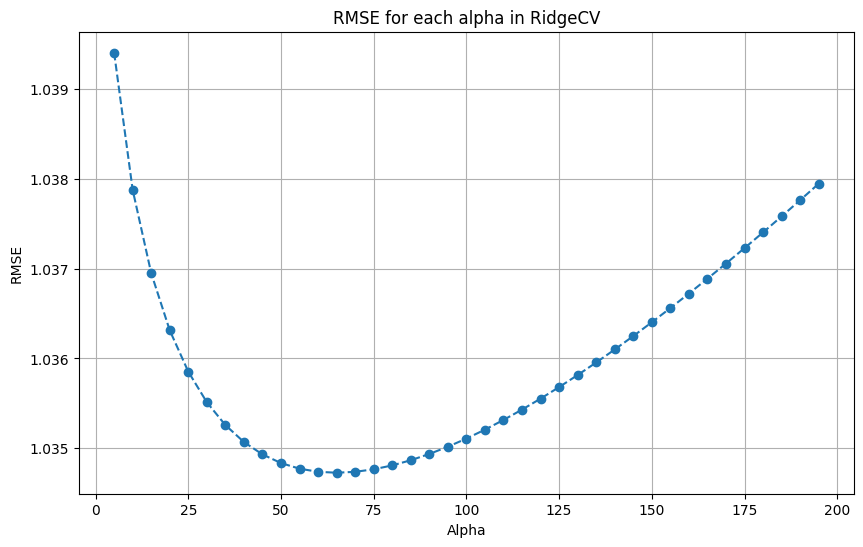

In [52]:
plt.figure(figsize=(10, 6))
plt.plot(alphas, rmse_values, marker='o', linestyle='--')
plt.xlabel('Alpha')
plt.ylabel('RMSE')
plt.title('RMSE for each alpha in RidgeCV')
plt.grid(True)
plt.show()

In [55]:
alpha_rmse_df = pd.DataFrame(
    {
        'alpha' : alphas, 
        'rmse' : rmse_values
    }   
)

alpha_rmse_df.sort_values(by='rmse', ascending=True)

,alpha,rmse
12,65,1.034728
13,70,1.034738
11,60,1.034739
14,75,1.034766
10,55,1.034773
15,80,1.034810
9,50,1.034836
16,85,1.034867
8,45,1.034932
17,90,1.034937


In [26]:
list(range(50,1000,2))

[50,
 52,
 54,
 56,
 58,
 60,
 62,
 64,
 66,
 68,
 70,
 72,
 74,
 76,
 78,
 80,
 82,
 84,
 86,
 88,
 90,
 92,
 94,
 96,
 98,
 100,
 102,
 104,
 106,
 108,
 110,
 112,
 114,
 116,
 118,
 120,
 122,
 124,
 126,
 128,
 130,
 132,
 134,
 136,
 138,
 140,
 142,
 144,
 146,
 148,
 150,
 152,
 154,
 156,
 158,
 160,
 162,
 164,
 166,
 168,
 170,
 172,
 174,
 176,
 178,
 180,
 182,
 184,
 186,
 188,
 190,
 192,
 194,
 196,
 198,
 200,
 202,
 204,
 206,
 208,
 210,
 212,
 214,
 216,
 218,
 220,
 222,
 224,
 226,
 228,
 230,
 232,
 234,
 236,
 238,
 240,
 242,
 244,
 246,
 248,
 250,
 252,
 254,
 256,
 258,
 260,
 262,
 264,
 266,
 268,
 270,
 272,
 274,
 276,
 278,
 280,
 282,
 284,
 286,
 288,
 290,
 292,
 294,
 296,
 298,
 300,
 302,
 304,
 306,
 308,
 310,
 312,
 314,
 316,
 318,
 320,
 322,
 324,
 326,
 328,
 330,
 332,
 334,
 336,
 338,
 340,
 342,
 344,
 346,
 348,
 350,
 352,
 354,
 356,
 358,
 360,
 362,
 364,
 366,
 368,
 370,
 372,
 374,
 376,
 378,
 380,
 382,
 384,
 386,
 388,
 390,

In [23]:
model = RidgeCV(alphas=range(5, 50, 5)).fit(X=design_matrix, y=data['PM'])

players = noc.players_name(design_matrix.columns[::2].astype(int))

results = pd.DataFrame({
    'Player': players,
    'ORAPM': model.coef_[::2],
    'DRAPM': model.coef_[1::2],
    'Absolute RAPM': np.abs(model.coef_[::2]) + np.abs(model.coef_[1::2])
})


# fill in PM for each player. here's the logic
# 1. since each PM corresponds to a point change, we can multiply it by the indicator of the player to get how much that contributes for the player's individual PM
# 2. adding offensive and defensive together gives us all the indicators for every stints
# 3. summing all the stint PMs multiplied by the indicators gives the
pm = np.empty(len(players))
for i in range(len(players)): 
    indicators = design_matrix.iloc[:, 2*i] + design_matrix.iloc[:, 2*i+1]
    pm[i] = np.sum(indicators * data['PM']) / np.count_nonzero(indicators)

results['Average PM'] = pm

results.head()

,Player,ORAPM,DRAPM,Absolute RAPM,Average PM
0,LeBron James,0.185277,-0.195133,0.380411,0.009829
1,Udonis Haslem,-0.026806,-0.077682,0.104487,-0.857143
2,Chris Paul,0.109621,-0.128424,0.238045,0.030675
3,Kyle Lowry,0.160258,-0.175860,0.336119,0.001596
4,P.J. Tucker,0.263167,-0.097582,0.360750,-0.024038


In [22]:
results.to_csv('results/odrapm_alpha-50_results.csv')